In [9]:
import open3d as o3d
from open3d import JVisualizer
import numpy as np
import matplotlib.pyplot as plt
import copy

In [10]:
# image_num = 16087242271484966
# color_raw = o3d.io.read_image('images/ground_arrow/color/color{}.png'.format(image_num))
# depth_raw = o3d.io.read_image('images/ground_arrow/depth/depth{}.png'.format(image_num))
image_num = 16087244643814638
color_raw = o3d.io.read_image('images/pot/color/color{}.png'.format(image_num))
depth_raw = o3d.io.read_image('images/pot/depth/depth{}.png'.format(image_num))
rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)

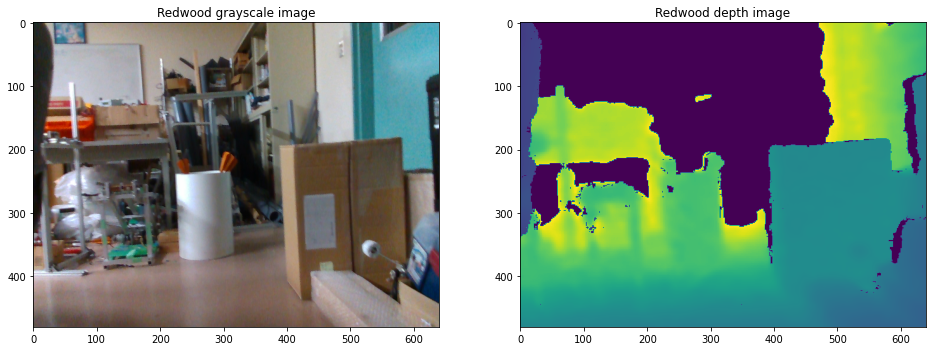

In [11]:
plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.title('Redwood grayscale image')
plt.imshow(rgbd_image.color)
plt.subplot(1, 2, 2)
plt.title('Redwood depth image')
plt.imshow(rgbd_image.depth)
plt.show()

In [16]:
pcd = o3d.geometry.PointCloud.create_from_rgbd_image(
    rgbd_image,
    o3d.camera.PinholeCameraIntrinsic(
        o3d.camera.PinholeCameraIntrinsicParameters.PrimeSenseDefault))
visualizer = JVisualizer()
visualizer.add_geometry(pcd)
visualizer.show()
o3d.visualization.draw_geometries([pcd])

JVisualizer with 1 geometries

In [13]:
def plane_segmentation(pcd):
    plane_model, inliers = pcd.segment_plane(distance_threshold=0.01,
                                             ransac_n=3,
                                             num_iterations=1000)
    [a, b, c, d] = plane_model
    print(f"Plane equation: {a:.2f}x + {b:.2f}y + {c:.2f}z + {d:.2f} = 0")

    inlier_cloud = pcd.select_by_index(inliers)
    inlier_cloud.paint_uniform_color([1.0, 0, 0])
    outlier_cloud = pcd.select_by_index(inliers, invert=True)

    return inlier_cloud, outlier_cloud

pcd_plane, pcd_no_plane = plane_segmentation(pcd)
o3d.visualization.draw_geometries([pcd_plane, pcd_no_plane])
o3d.visualization.draw_geometries([pcd_no_plane])

Plane equation: 0.07x + 1.00y + 0.02z + -0.60 = 0


In [15]:
def DBSCAN_clustering(pcd):
    with o3d.utility.VerbosityContextManager(
            o3d.utility.VerbosityLevel.Debug) as cm:
        labels = np.array(
            pcd.cluster_dbscan(eps=0.02, min_points=10, print_progress=True))

    max_label = labels.max()
    print(f"point cloud has {max_label + 1} clusters")
    colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
    colors[labels < 0] = 0
    pcd.colors = o3d.utility.Vector3dVector(colors[:, :3])
    return pcd, labels

pcd_clastering, labels = DBSCAN_clustering(pcd_no_plane)
o3d.visualization.draw_geometries([pcd_clastering])

[Open3D DEBUG] Precompute Neighbours
[Open3D DEBUG] Done Precompute Neighbours
[Open3D DEBUG] Compute Clusters
[Open3D DEBUG] Done Compute Clusters: 223
point cloud has 223 clusters


In [14]:
np.set_printoptions(threshold=100)
print(labels)

NameError: name 'labels' is not defined

In [7]:
def select_class(labels, min_point_num, max_point_num):
    classes = []
    for i in range(max(labels)):
        count = np.count_nonzero(labels==i)
        if min_point_num < count < max_point_num: classes.append(i)
        print(i, count)
    return classes

classes = select_class(labels, 100, 1000)
print(classes)

0 94647
1 27
2 108
3 35
4 258
5 214
6 18
7 53677
8 27
9 25
10 182
11 787
12 56
13 42
14 107
15 13
16 39
17 11
18 27
19 1039
20 136
21 5104
22 884
23 37
24 34503
[2, 4, 5, 10, 11, 14, 20, 22]


In [8]:
def display_inlier_outlier(cloud, ind, invert=False):
    inlier_cloud = cloud.select_by_index(ind, invert=not(invert))
    outlier_cloud = cloud.select_by_index(ind, invert=invert)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

In [9]:
def pcd_select_by_label(pcd, labels, targets, invert=False):
    indexs = np.array([], dtype=np.int)
    for target in targets:
        indexs_part = np.where(labels==target)[0]
        indexs = np.concatenate([indexs, indexs_part])
    return pcd.select_by_index(indexs, invert=invert)

# pcd_part = pcd_select_by_label(pcd_row, labels, [5, 13]) 
classes = select_class(labels, 100, 1000)
pcd_part = pcd_select_by_label(pcd_clastering, labels, classes)
o3d.visualization.draw_geometries([pcd_part])

0 94647
1 27
2 108
3 35
4 258
5 214
6 18
7 53677
8 27
9 25
10 182
11 787
12 56
13 42
14 107
15 13
16 39
17 11
18 27
19 1039
20 136
21 5104
22 884
23 37
24 34503


In [10]:
pcd_arrow = pcd_select_by_label(pcd_clastering, labels, [8, 11])
o3d.visualization.draw_geometries([pcd_arrow])
aabb = pcd_arrow.get_axis_aligned_bounding_box()
aabb.color = (1, 0, 0)
obb = pcd_arrow.get_oriented_bounding_box()
obb.color = (0, 1, 0)
o3d.visualization.draw_geometries([pcd_clastering, aabb, obb])
o3d.visualization.draw_geometries([pcd_row, aabb, obb])

In [11]:
from scipy.spatial.transform import Rotation

print(obb.R)
rot = Rotation.from_dcm(obb.R)
print(rot.as_euler('XYZ'))
print(obb.center)
print(obb.extent)

[[-0.00109357  0.97467684 -0.22361545]
 [-0.68616753 -0.163399   -0.70885463]
 [ 0.72744273 -0.15266248 -0.66897028]]
[ 2.5955134   0.57228768 -0.14811192]
[ 0.09137896 -0.12894202  1.14196643]
[0.5882473  0.18682386 0.0171267 ]


In [7]:
print(np.array(pcd.points))

[[-0.72846002 -0.54606001  1.19700003]
 [-0.72800003 -0.54742859  1.20000005]
 [-0.72571431 -0.54742859  1.20000005]
 ...
 [ 0.42635713  0.32161428  0.70499998]
 [ 0.42769999  0.32161428  0.70499998]
 [ 0.42843428  0.32115809  0.704     ]]


In [38]:
print(np.array(pcd.colors))

[[0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]
 ...
 [0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]
 [0.12156863 0.46666667 0.70588235]]


In [39]:
class ModelBaseMatching():
    def __init__(self) -> None:
        super().__init__()

    def preprocess_point_cloud(self, pcd, voxel_size):
        print(":: Downsample with a voxel size {:.3}.".format(voxel_size))
        pcd_down = pcd.voxel_down_sample(voxel_size)

        radius_normal = voxel_size * 2
        print(
            ":: Estimate normal with search radius {:.3}.".format(radius_normal))
        pcd_down.estimate_normals(
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))

        radius_feature = voxel_size * 5
        print(
            ":: Compute FPFH feature with search radius {:.3}.".format(radius_feature))
        pcd_fpfh = o3d.registration.compute_fpfh_feature(
            pcd_down,
            o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
        return pcd_down, pcd_fpfh

    def execute_global_registration(self, source_down, target_down, source_fpfh,
                                    target_fpfh, voxel_size):
        distance_threshold = voxel_size * 1.5
        print(":: RANSAC registration on downsampled point clouds.")
        print(
            "   Since the downsampling voxel size is {:.3},".format(voxel_size))
        print("   we use a liberal distance threshold {:.3}.".format(
            distance_threshold))
        result = o3d.registration.registration_ransac_based_on_feature_matching(
            source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
            o3d.registration.TransformationEstimationPointToPoint(False), 4, [
                o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
                o3d.registration.CorrespondenceCheckerBasedOnDistance(
                    distance_threshold)
            ], o3d.registration.RANSACConvergenceCriteria(4000000, 500))
        return result

    def refine_registration(self, source, target, voxel_size, result_ransac):
        distance_threshold = voxel_size * 0.4
        print(":: Point-to-plane ICP registration is applied on original point")
        print("   clouds to refine the alignment. This time we use a strict")
        print("   distance threshold {:.3}.".format(distance_threshold))
        result = o3d.registration.registration_icp(
            source, target, distance_threshold, result_ransac.transformation,
            o3d.registration.TransformationEstimationPointToPlane())
        return result

    def draw_registration_result(self, source, target, transformation):
        source_temp = copy.deepcopy(source)
        target_temp = copy.deepcopy(target)
        source_temp.paint_uniform_color([1, 0.706, 0])
        # target_temp.paint_uniform_color([0, 0.651, 0.929])
        source_temp.transform(transformation)
        o3d.visualization.draw_geometries([source_temp, target_temp])

    def calc(self, source, target, voxel_size=0.01):
        # Global Registration by RANSAC
        source_down, source_fpfh = self.preprocess_point_cloud(
            source, voxel_size)
        target_down, target_fpfh = self.preprocess_point_cloud(
            target, voxel_size)
        result_ransac = self.execute_global_registration(
            source_down, target_down, source_fpfh, target_fpfh, voxel_size)

        # refine by ICP
        return self.refine_registration(
            source_down, target_down, voxel_size, result_ransac)

In [40]:
    mbm = ModelBaseMatching()

    # load data
    mesh_arrow = o3d.io.read_triangle_mesh('arrow.obj')
    source = mesh_arrow.sample_points_uniformly(number_of_points=5000)
    source = source.voxel_down_sample(voxel_size=0.001)

    target = pcd
    o3d.visualization.draw_geometries([target])

    mbm.draw_registration_result(source, target, np.eye(4))

    # model base matching
    result = mbm.calc(source, target)
    mbm.draw_registration_result(source, target, result.transformation)
    print(result.transformation)

:: Downsample with a voxel size 0.01.
:: Estimate normal with search radius 0.02.
:: Compute FPFH feature with search radius 0.05.
:: Downsample with a voxel size 0.01.
:: Estimate normal with search radius 0.02.
:: Compute FPFH feature with search radius 0.05.
:: RANSAC registration on downsampled point clouds.
   Since the downsampling voxel size is 0.01,
   we use a liberal distance threshold 0.015.
:: Point-to-plane ICP registration is applied on original point
   clouds to refine the alignment. This time we use a strict
   distance threshold 0.004.
[[-2.81682623e-01  9.30783606e-01  2.33016692e-01  7.34230641e-01]
 [ 7.18297123e-01  3.65570073e-01 -5.91952502e-01 -6.07525049e-01]
 [-6.36163614e-01  6.32486183e-04 -7.71553923e-01  1.44357251e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]]


In [41]:
# Statistical outlier removal
print("Statistical oulier removal")
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=20, std_ratio=2.0)
display_inlier_outlier(pcd, ind, invert=True)
o3d.visualization.draw_geometries([cl])

Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [8]:
# Radius outlier removal

print("Radius oulier removal")
cl, ind = pcd.remove_radius_outlier(nb_points=16, radius=0.05)
display_inlier_outlier(pcd, ind, invert=True)
o3d.visualization.draw_geometries([cl])

Radius oulier removal


NameError: name 'display_inlier_outlier' is not defined